### installs

In [1]:
#check if this colab environment
%matplotlib inline
on_colab = 'google.colab' in str(get_ipython())


In [2]:
import os

In [3]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

In [4]:
# !wget https://github.com/NVIDIAGameWorks/kaolin/raw/4d8f49dd3e617cb1fec3e2c2bc3b2903ff952321/examples/samples/rendered_clock.zip
# !unzip rendered_clock.zip
if on_colab:
  !git clone https://github.com/NVIDIAGameWorks/kaolin.git
  !pip install kaolin==0.16.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.4.0_cu121.html --quiet
  !pip install torch torchvision transformers diffusers pillow  --quiet
  !pip install objaverse --quiet
  !pip install lpips
  !pip install -U "comet_ml>=3.44.0" --quiet
  !cp /content/kaolin/kaolin/render/lighting/sg.py /usr/local/lib/python3.10/dist-packages/kaolin/render/lighting/sg.py
# !wget https://raw.githubusercontent.com/NVIDIAGameWorks/kaolin/bcbc92f4ed6f176e9d320932ea5ee1262e2ce059/examples/samples/sphere.obj

In [5]:
if on_colab:
  checkpoint_root = '/content/drive/MyDrive/Adver_diff_checkpoints/'
else:
  checkpoint_root = '/home/dcor/niskhizov/adv_diff_checkpoints/'

In [6]:
#@title comet stuff
import comet_ml
from comet_ml.integration.pytorch import watch

comet_ml.login(project_name="Adversarial-diff-rendering-notebook-V3")

In [7]:
from IPython.display import clear_output
clear_output()

### imports

In [1]:
import kaolin
import kaolin as kal
import pickle
import torch
import objaverse


import math
import matplotlib.pyplot as plt

from kaolin.render.lighting import SgLightingParameters
import numpy as np

from datetime import datetime

Warp 1.4.2 initialized:
   CUDA Toolkit 12.6, Driver 12.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "Tesla V100-SXM2-32GB" (32 GiB, sm_70, mempool enabled)
   Kernel cache:
     /home/dcor/niskhizov/.cache/warp/1.4.2


###  dynamic light, camera rendering funcs

In [2]:


IMAGE_SIZE = 1024

def make_camera(eye):
  return kal.render.camera.Camera.from_args(eye=torch.tensor(eye),
                                         at=torch.tensor([0., 0., 0.]),
                                         up=torch.tensor([0., 1., 0]),
                                         fov=math.pi * 45 / 180,
                                            near=0.1, far=10000.,
                                         width=IMAGE_SIZE,
                                            height=IMAGE_SIZE,
                                            device='cuda')
forbidden_theta = []
forbidden_phi = []

resolution = 20
for theta in np.linspace(1, 0.9, 3):
    forbidden_theta.append(theta)

for phi in np.linspace(0.001, 3, resolution):
    forbidden_phi.append(phi)

forbidden_theta = set(forbidden_theta)
forbidden_phi = set(forbidden_phi)

def random_polar(r_range, phi_range, theta_range):
  done = False
  while not done:
    r = np.random.uniform(r_range[0], r_range[1])
    theta = np.random.uniform(theta_range[0], theta_range[1])
    phi = np.random.uniform(phi_range[0], phi_range[1])
    if theta not in forbidden_theta and phi not in forbidden_phi:
      done = True
  return [r, theta, phi]


def polar_to_cartesian(r, phi, theta):
  y = r * math.cos(theta)
  z = r * math.sin(theta) * math.cos(phi)
  x = r * math.sin(theta) * math.sin(phi)
  return [x,y,z]

def random_light(strength_range = [8,15],suns_range=[1, 5], phi_range=[0, math.pi * 2], theta_range=[0, math.pi / 2]):
  n_suns = int(np.random.uniform(suns_range[0],suns_range[1]))
  light_directions = []
  for i in range(n_suns):
    [r, theta, phi] = random_polar(r_range=[1, 5], phi_range=phi_range, theta_range=theta_range)
    direction = np.array(polar_to_cartesian(r, phi, theta))
    direction = direction / np.sqrt(np.sum(direction * direction))
    light_directions.append(direction)

  light_directions = torch.tensor(np.array(light_directions)).cuda()

  strength = np.random.uniform(strength_range[0],strength_range[1])
  lighting = SgLightingParameters.from_sun(light_directions.float(), strength).cuda()

  return lighting, (strength,light_directions)

def polar_camera_and_light(r, phi, theta):
  eye = polar_to_cartesian(r, phi, theta)
  camera = make_camera(eye)
  eye = np.array(eye)
  eye_norm = np.sqrt(np.sum(eye * eye))

  n_suns = int(np.random.uniform(1, 5))
  light_directions = []
  light_direction = torch.tensor(eye / eye_norm, dtype=torch.float32).view(1, 1, 3).cuda()
  strength = np.random.uniform(4, 10)
  lighting = SgLightingParameters.from_sun(light_direction.float(), strength).cuda()
  return camera, lighting

theta_eps = 0.3

def random_camera_and_light(r_range = [0, 5], phi_range=[0, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,0]):
  [r, theta, phi] = random_polar(r_range, phi_range, theta_range)
  return polar_camera_and_light(r, phi, theta), (r, phi, theta)


def render(in_cam, mesh, lighting, pbr_mat=None):
    if pbr_mat is not None:
      render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting, custom_materials = [pbr_mat])
    else:
      render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting)
    img = render_res[kal.render.easy_render.RenderPass.render].squeeze(0).clamp(0, 1)
    return img

# Show simple render

### lpf noise

In [ ]:
from torch import nn
import torch.nn.functional as F

def generate_low_frequency_noise_fft(noise, cutoff_ratio: float = 0.05):
    """Generates low-frequency noise using FFT-based filtering."""
    # Generate random white noise
    size = noise.shape[0]
    # Perform FFT to get frequency domain representation
    noise_fft = torch.fft.fft2(noise)

    # Shift the zero frequency component to the center
    noise_fft_shifted = torch.fft.fftshift(noise_fft)

    # Create a low-pass filter (circle mask in frequency domain)
    mask = torch.zeros_like(noise_fft_shifted)
    center = size // 2
    cutoff = int(center * cutoff_ratio)  # Controls how much low frequency is kept

    for i in range(size):
        for j in range(size):
            if (i - center) ** 2 + (j - center) ** 2 < cutoff ** 2:
                mask[i, j] = 1

    # Apply the mask to the FFT coefficients
    low_freq_fft = noise_fft_shifted * mask

    # Inverse FFT to convert back to spatial domain
    low_freq_fft_shifted_back = torch.fft.ifftshift(low_freq_fft)
    low_freq_noise = torch.fft.ifft2(low_freq_fft_shifted_back).real

    return low_freq_noise

class SmoothNoise(nn.Module):
  def __init__(self, noise_shape):
      super().__init__()
      # generate noise parameter for each of the 3 channels

      self.noise_parameter = nn.ParameterList([nn.Parameter(torch.randn(noise_shape,noise_shape)) for i in range(3)])

  def forward(self, texture_map):
      all_channels_noise =  torch.stack([generate_low_frequency_noise_fft(p) for p in self.noise_parameter])
      if texture_map.shape[-1] == 3:
        all_channels_noise = all_channels_noise.T
      output = texture_map + all_channels_noise
      return output


def gaussian_kernel(size: int, sigma: float):
    """Generates a 2D Gaussian kernel."""
    coords = torch.arange(size).float()
    coords -= (size - 1) / 2.0
    g = torch.exp(-coords.pow(2) / (2 * sigma ** 2))
    g = g / g.sum()  # Normalize
    g_2d = g.unsqueeze(0) * g.unsqueeze(1)  # Outer product to create 2D kernel
    return g_2d

# Create Gaussian kernel
kernel_size = 11  # Kernel size (odd number)
sigma = 10        # Standard deviation of the Gaussian
num_noises = 1
gaussian_filter = gaussian_kernel(kernel_size, sigma).unsqueeze(0).repeat(3,1,1).unsqueeze(1)

conv_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=kernel_size,
                       padding=kernel_size // 2, bias=False,
                       padding_mode='circular', groups=3)

# Initialize the Conv2d weights with the Gaussian kernel
with torch.no_grad():
    conv_layer.weight = nn.Parameter(gaussian_filter)

#freeze conv_layer parameters
for param in conv_layer.parameters():
  param.requires_grad = False

class GNSmoothNoise(nn.Module):
  def __init__(self, noise_shape, num_noises=num_noises, zero_init=True):
      super().__init__()
      # generate noise parameter for each of the 3 channels
      self.kernel_size = kernel_size
      self.noise_parameter = nn.Parameter(torch.randn(num_noises,1,noise_shape,noise_shape)*5)
      if zero_init:
        self.noise_parameter.data = torch.zeros_like(self.noise_parameter) - 10

      self.conv_layer = conv_layer


  def forward(self, texture_map):
      return texture_map + conv_layer(self.noise_parameter).sum(0) * 0.1#(texture_map +  torch.sigmoid(self.conv_layer(self.noise_parameter).sum(0) ))/2

### Photographic augmentations

In [4]:
#@title augmentation
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

class PrintPhotographEffect:
    def __init__(self):
        self.downscale = T.Resize((300, 300))  # Simulate low-res printing
        self.upscale = T.Resize((1024, 1024))  # Upscale back to original size
        self.add_noise = T.Lambda(self._add_noise)  # Add random noise
        self.gaussian_blur = T.GaussianBlur(kernel_size=(5,5), sigma=(1.0, 4.0))  # Blur
        self.adjust_contrast = T.Lambda(self._adjust_contrast)  # Contrast adjustment
        self.vignette = T.Lambda(self._add_vignette)  # Vignette effect
        self.jitter = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5)
        # self.perspective_transformer = v2.RandomPerspective(distortion_scale=0.2, p=1.0)

    def _add_noise(self, img):
        rnd_scale = torch.FloatTensor(1).uniform_(0.01, 0.2).to(img.device)
        noise = torch.randn_like(img) * rnd_scale  # Gaussian noise
        return torch.clamp(img + noise, 0, 1)

    def _adjust_contrast(self, img,factor=1.2):
        factor = factor  # Slightly increase contrast
        mean = torch.mean(img, dim=(-2, -1), keepdim=True)
        return torch.clamp((img - mean) * factor + mean, 0, 1)

    def _add_vignette(self, img):
        _, height, width = img.shape
        y, x = torch.meshgrid(
            torch.linspace(-1, 1, height, device=img.device),
            torch.linspace(-1, 1, width, device=img.device)
        )
        vignette = 1 - torch.sqrt(x**2 + y**2)
        vignette = vignette.to(img.device).unsqueeze(0)  # Add channel dimension
        return torch.clamp(img * vignette, 0, 1)

    def __call__(self, img,upscale_first=False):
        img = img.permute(2,1,0)
        img = self.downscale(img)
        if upscale_first:
          img = self.upscale(img)

        img = self.add_noise(img)

        img = self.gaussian_blur(img)

        # img = self.adjust_contrast(img)

        img = self.jitter(img)
        # img = self.vignette(img)

        # img = self.perspective_transformer(img)
        if not upscale_first:
          img = self.upscale(img)

        return img.permute(2,1,0)

effect = PrintPhotographEffect()


### resnet classfier init

In [5]:


from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torchvision


weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = model.eval().cuda()


preprocess = weights.transforms()
#input image w x h x c

def resnet_predict(image):
  with torch.no_grad():
    prediction = resnet_predict_raw(image)
    prediction = prediction.squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    # return(f"class id - {class_id} {category_name}: {100 * score:.1f}%")
    return(f"{category_name}: {100 * score:.1f}%")



def resnet_predict_raw(image):

  image = image.permute(2, 0, 1)

  if image.shape != (3, 256, 256):
    rimage = torchvision.transforms.Resize((256, 256))(image)
  else:
    rimage = image

  # Step 3: Apply inference preprocessing transforms
  batch = preprocess(rimage).unsqueeze(0)

  # Step 4: Use the model and print the predicted category
  return model(batch)

### objaverse

In [13]:
# for x,y in zip(range(len(weights.meta["categories"])),weights.meta["categories"]):
#   print(x,y)

In [7]:
import objaverse
import os

uids = ['f53d75bd123b40bca14d12d54286f432']

objaverse.load_objects(
    uids,
    download_processes = 1
)
orig_mesh = kal.io.gltf.import_mesh(f'{os.path.expanduser("~")}/.objaverse/hf-objaverse-v1/glbs/000-027/f53d75bd123b40bca14d12d54286f432.glb')
# orig_mesh = kal.io.gltf.import_mesh("/home/dcor/niskhizov/ImageToStl.com_sheet-001.glb"
# orig_mesh = kal.io.obj.import_mesh("/home/dcor/niskhizov/a4-sheet-003.obj")
orig_mesh.vertices = kal.ops.pointcloud.center_points(orig_mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)


orig_mesh = kal.io.gltf.import_mesh("/home/dcor/niskhizov/ImageToStl.com_sheet-001.glb")
orig_mesh.materials[0].diffuse_texture = torch.ones(1024, 1024, 3).cuda()
# orig_mesh = kal.io.obj.import_mesh("/home/dcor/niskhizov/a4-sheet-003.obj")
orig_mesh.vertices = kal.ops.pointcloud.center_points(orig_mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)

/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/kaolin/io/gltf.py:285: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1560.)
  output = torch.frombuffer(


In [8]:
import copy
mesh = copy.deepcopy(orig_mesh)

In [16]:
# lighting.amplitude.dtype

In [17]:
# lighting.from_sun

29.23271996283476 tensor([[ 0.3371,  0.7563,  0.5607],
        [ 0.3214,  0.1282, -0.9382],
        [-0.0954,  0.9953,  0.0182]], device='cuda:0', dtype=torch.float64)
(3.843454038559041, 3.9414166206575096, 0.9926419082274134)
3.843454038559041


/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/kaolin/render/easy_render/mesh.py:282: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  im_bitangents = torch.nn.functional.normalize(torch.cross(im_tangents, im_base_normals), dim=-1)
/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_1744404/689522171.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

'envelope: 8.3%'

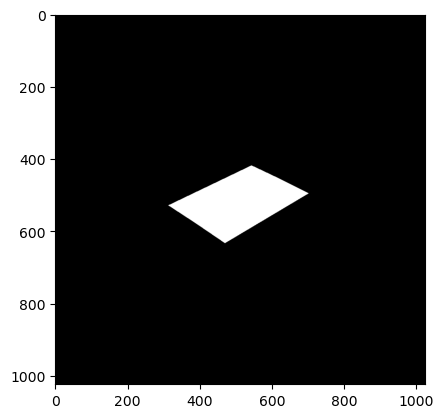

In [9]:
(camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.5, 4])#,phi_range=[ 0.2,0.2] ,theta_range=[math.pi / 2 - theta_eps, math.pi / 2 - theta_eps])
lighting, (strength,light_directions) = random_light(strength_range=[20,30])#kal.render.easy_render.default_lighting().cuda()
print(strength,light_directions)
# lighting.amplitude = torch.ones(1,3).cuda() * 8
print((r, phi, theta) )
print(r)


# mesh.materials[0].diffuse_texture = mesh.materials[0].diffuse_texture

img = render(camera, mesh.cuda(), lighting.cuda())

plt.imshow(img.detach().cpu())


resnet_predict(torch.tensor(img).cuda())

/tmp/ipykernel_1744404/1126165670.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_score = resnet_predict(torch.tensor(img).cuda())


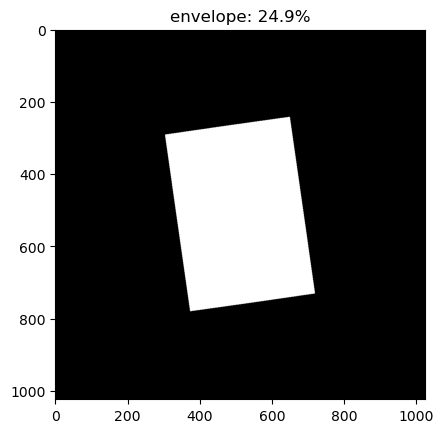

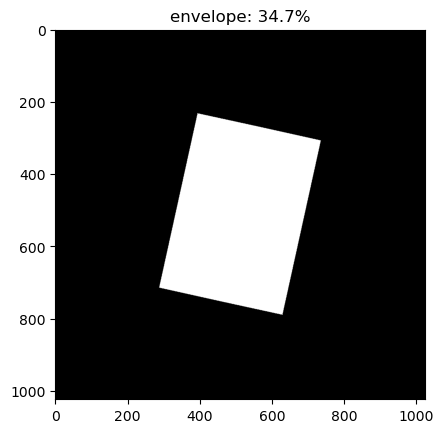

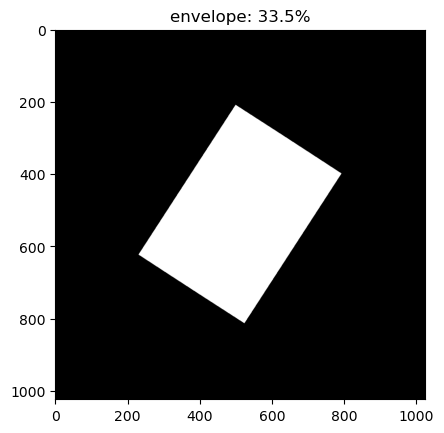

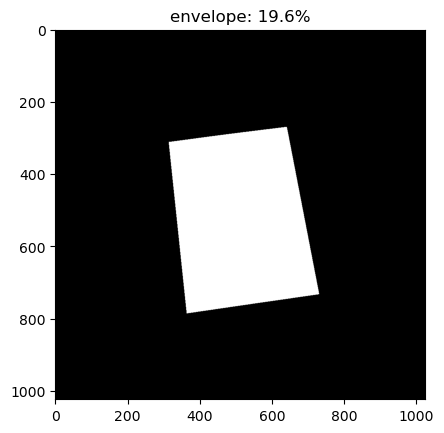

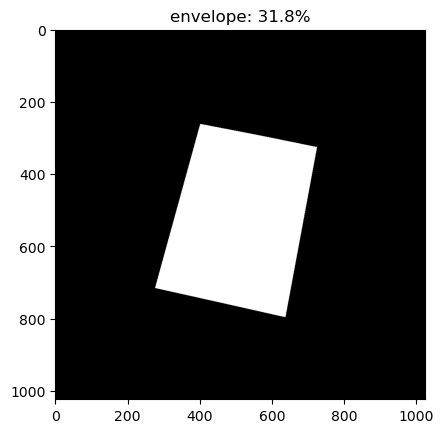

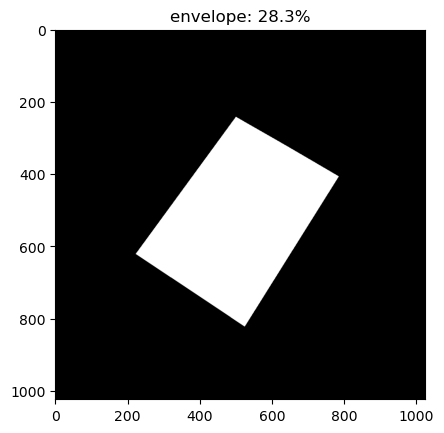

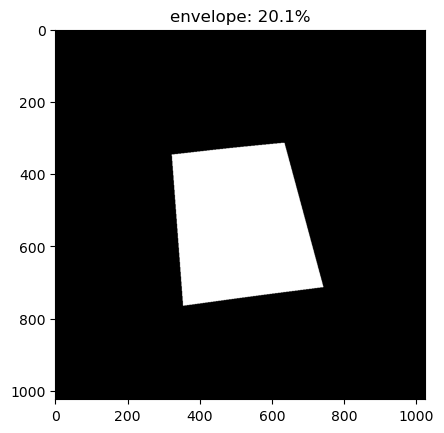

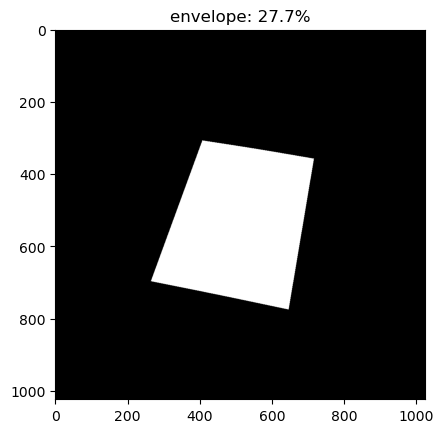

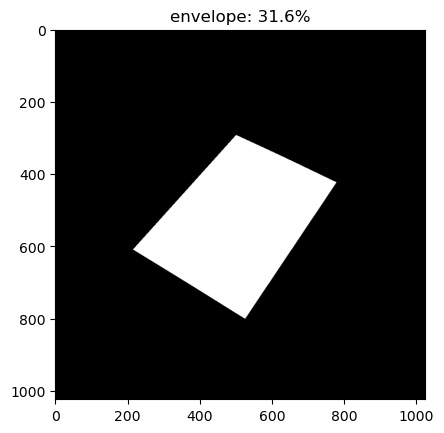

In [10]:
for theta in np.linspace(0.0001, 0.6, 3):
  for phi in np.linspace(3, 10, 3):
    camera, _ = polar_camera_and_light(2.5, phi, theta)
    # print(phi,theta)
    with torch.no_grad():
      img = render(camera, mesh.cuda(), lighting.cuda())
      img_score = resnet_predict(torch.tensor(img).cuda())

    # plot both images in the same figure
    # put the score as the images title
    fig, axs = plt.subplots(1, 1)
    axs.imshow(img.detach().cpu())


    axs.set_title(img_score)


In [20]:

batch_size = 1

# analog_clock_class = torch.tensor([409]*batch_size).cuda()
# wall_clock_class = torch.tensor([892]*batch_size).cuda()
# orig_class = torch.tensor([948]*batch_size).cuda()
orig_clases = [torch.tensor([x]*batch_size).cuda() for x in range(948,959)]



critereon = torch.nn.CrossEntropyLoss()
adv_direction = 100 #None#953# pineapple #None



if adv_direction:
  directed_class = torch.tensor([adv_direction]*batch_size).cuda()

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [12]:
SN = GNSmoothNoise(1024, zero_init=False).to(device)
SN2 = GNSmoothNoise(1024, zero_init=False).to(device)

#### load saved weights
find the most recent file in /content/drive/MyDrive/Adver_diff_checkpoints

In [14]:

import glob
import re
import os
import torch
# weights_paths = glob.glob('/content/drive/MyDrive/Adver_diff_checkpoints/*_without_sds_bs_20.pt')
# weights_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
# print(weights_paths[-1])

files = glob.glob('/home/dcor/niskhizov/adv_diff_checkpoints//*.pt')
files.sort(key=os.path.getmtime)

print(files[-1])

SN.noise_parameter = torch.load(files[-1]).noise_parameter

/home/dcor/niskhizov/adv_diff_checkpoints/234000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt


/tmp/ipykernel_1744404/2016630400.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  SN.noise_parameter = torch.load(files[-1]).noise_parameter


In [24]:
# orig_mesh.materials[0].diffuse_texture.min()

In [25]:
# sn = SN(torch.zeros(3,1024,1024).cuda()).cpu().detach()
# print(sn[0]==sn[1])
# # plt.imshow(SN(torch.zeros(3,1024,1024).cuda()).cpu().detach()[2])
# plt.imshow(SN(torch.zeros(3,1024,1024).cuda()).cpu().detach().permute(2,1,0))
# # plt.imshow(SN.noise_parameter.data[5].cpu().permute(2,1,0))
# # plt.imshow(orig_mesh.materials[0].diffuse_texture,aspect='auto')

### Physical testing

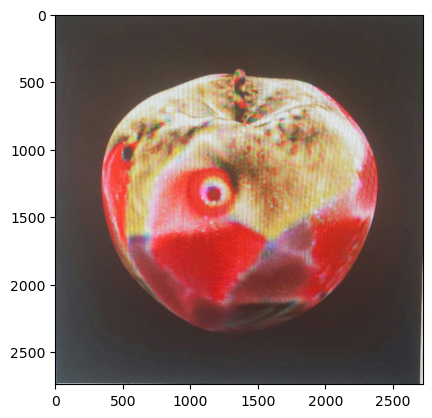

In [26]:
# load 20241130_202829.jpg 
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = '20241130_220012.jpg'  # Replace with the path to your image
image = Image.open(image_path)

im = image.convert('RGB')
img = torch.tensor(np.array(im))
img = img / 255

plt.imshow(img)

Text(0.5, 1.0, 'blsw adv | black swan: 20.6%')

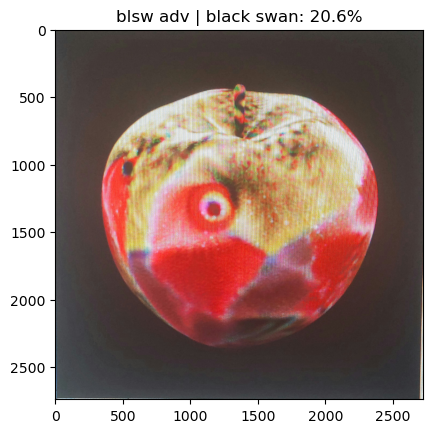

In [27]:
title = 'blsw adv | '+resnet_predict(img.cuda())
plt.imshow(img)
plt.title(title)



In [28]:
raise

RuntimeError: No active exception to reraise

### GIF

In [15]:
#freeze all parameters of resnet model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
for param in model.parameters():
  param.requires_grad = False

import copy
mesh = copy.deepcopy(orig_mesh).to(device)
mesh2 = copy.deepcopy(orig_mesh).to(device)
orig_mesh = orig_mesh.to(device)



In [16]:
import glob
import re

files = glob.glob('/home/dcor/niskhizov/adv_diff_checkpoints//*')
files.sort(key=os.path.getmtime)

for w in files[-10:]:
    print(w)

a = files[-1]
print()


files = glob.glob('/home/dcor/niskhizov/adv_diff_checkpoints//*1_sds_bs_1_sds_only_blsw_*.pt')


# files.sort(key=lambda f: int(re.sub('\D', '', f)))
files.sort(key=os.path.getmtime)



for w in files[-10:]:
    print(w)

b = files[-1]


/home/dcor/niskhizov/adv_diff_checkpoints/216000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt
/home/dcor/niskhizov/adv_diff_checkpoints/218000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt
/home/dcor/niskhizov/adv_diff_checkpoints/220000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt
/home/dcor/niskhizov/adv_diff_checkpoints/222000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt
/home/dcor/niskhizov/adv_diff_checkpoints/224000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt
/home/dcor/niskhizov/adv_diff_checkpoints/226000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt
/home/dcor/niskhizov/adv_diff_checkpoints/228000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt
/home/dcor/niskhizov/adv_diff_checkpoints/230000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt
/home/dcor/niskhizov/adv_diff_ch

In [17]:
a = '/home/dcor/niskhizov/adv_diff_checkpoints/234000_1_sds_bs_1_l2_blswn_photo_augmentations_a4_paper_2024-12-07 21:25:43.pt'
b = '/home/dcor/niskhizov/adv_diff_checkpoints/18000_2024-11-30 20:39:16_0_sds_bs_1_adv_only_blsw_photo_augmentations.pt'

In [19]:

SN.noise_parameter = torch.load( a).noise_parameter
SN.to(device)


# SN2.noise_parameter = torch.load( b).noise_parameter
# SN2.to(device)
SN2 = SN
mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T.to(device)).T

/tmp/ipykernel_1744404/1779434546.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  SN.noise_parameter = torch.load( a).noise_parameter
/tmp/ipykernel_1744404/1779434546.p

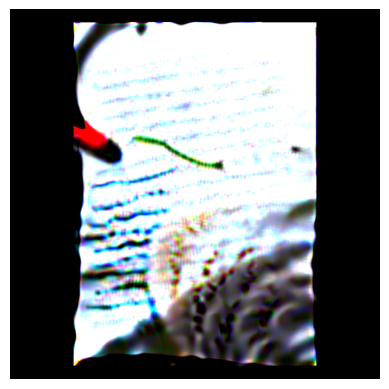

In [53]:
lighting, _ = random_light(strength_range=[10,10],suns_range=[3, 3])
camera, _ = polar_camera_and_light(1.3, 0.000000001, 0.000000001)
img = render(camera, mesh, lighting)
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
plt.grid(False)
plt.imshow(img.detach().cpu())
# save img to png using PIL
from PIL import Image
img_pil = Image.fromarray((img.detach().cpu().numpy() * 255).astype(np.uint8))
img_pil.save("test2.png")


/tmp/ipykernel_396253/409614003.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_score = resnet_predict(torch.tensor(img).cuda())
/tmp/ipykernel_396253/409614003.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img2_score = resnet_predict(torch.tensor(img2).cuda())
/tmp/ipykernel_396253/409614003.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_img_score = resnet_predict(torch.tensor(orig_img).cuda())


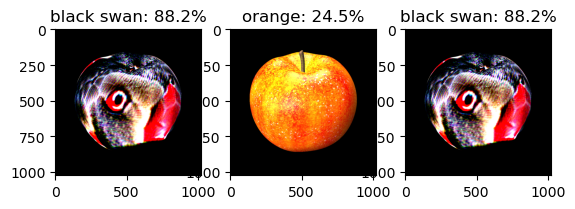

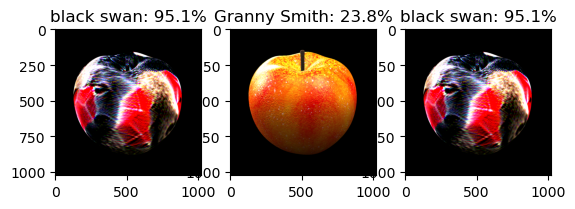

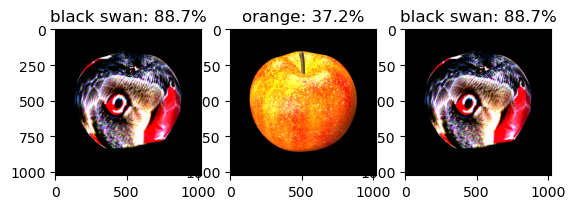

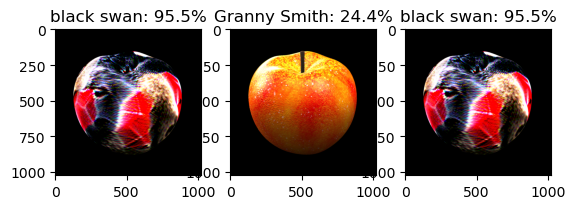

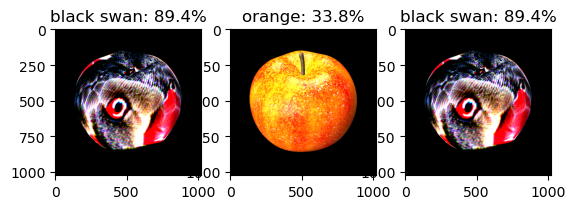

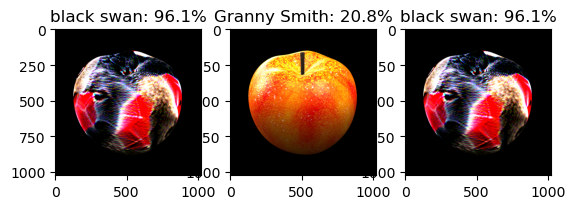

In [55]:
# (camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.8, 2.5], phi_range=[3, math.pi * 2], theta_range=[ math.pi / 2 - theta_eps,1])

lighting, _ = random_light(strength_range=[15,15],suns_range=[7, 7])
# lighting.amplitude = torch.ones(1,3).cuda() * 10
mesh.materials[0].diffuse_texture = SN(orig_mesh.materials[0].diffuse_texture.T.to(device)).T
mesh2.materials[0].diffuse_texture = SN2(orig_mesh.materials[0].diffuse_texture.T.to(device)).T

resolution = 20 # 100
plots = []
count = 0
for theta in np.linspace(1, 0.9, 3):
  for phi in np.linspace(0.001, 3, resolution):
    camera, _ = polar_camera_and_light(1.7, phi, theta)
    # print(phi,theta)
    with torch.no_grad():
      img = render(camera, mesh, lighting)
      img2 = render(camera, mesh2, lighting)
      orig_img = render(camera, orig_mesh, lighting)

      img_score = resnet_predict(torch.tensor(img).cuda())
      img2_score = resnet_predict(torch.tensor(img2).cuda())
      orig_img_score = resnet_predict(torch.tensor(orig_img).cuda())
    # plot both images in the same figure
    # put the score as the images title
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(img.detach().cpu())
    axs[1].imshow(orig_img.detach().cpu())
    axs[2].imshow(img2.detach().cpu())

    axs[0].set_title(img_score)
    axs[1].set_title(orig_img_score)
    axs[2].set_title(img2_score)

    count +=1
    if count % 10 == 0:
      plt.show()

    plots.append([img,orig_img,img2,img_score,orig_img_score,img2_score])
    plt.close()


black swan: 86.0%


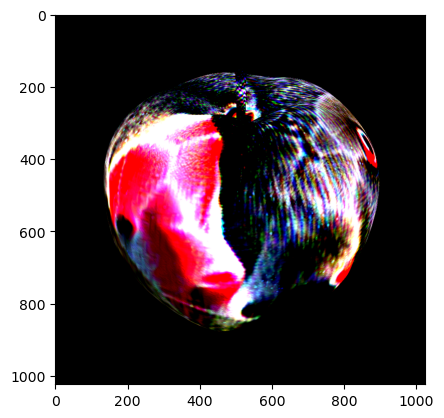

In [56]:
m = plots[0][2] 
# plot plots[0][0]
plt.imshow(m.detach().cpu())
print(resnet_predict(m))
from PIL import Image
import numpy as np
img = Image.fromarray(np.uint8(m.detach().cpu().numpy()*255), 'RGB')
img.save('adv_image.jpg')


In [57]:
import matplotlib.animation as animation

def save_plots(plots,t,name='image.gif'):
  #make animation out of plots list at the same figure
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  # add title to the entire fig
  fig.suptitle(t)

  def update(frame):
    axs[0].imshow(plots[frame][0].detach().cpu())
    axs[1].imshow(plots[frame][1].detach().cpu())
    # axs[2].imshow(plots[frame][2].detach().cpu())

    axs[0].set_title('adv image score: ' + plots[frame][3])
    axs[1].set_title('orig image score: ' + plots[frame][4])
    # axs[2].set_title('adv sds image score: ' + plots[frame][5])

    return axs

  ani = animation.FuncAnimation(fig, update, frames=len(plots), interval=2500, repeat=True)

  # Display the animation
  # plt.show()
  #save the animation
  gif_file = name
  ani.save(gif_file, writer='pillow', fps=3)

  print(f"Animation saved as {gif_file}")

Animation saved as blswn_dargeted_blswn_sds.gif


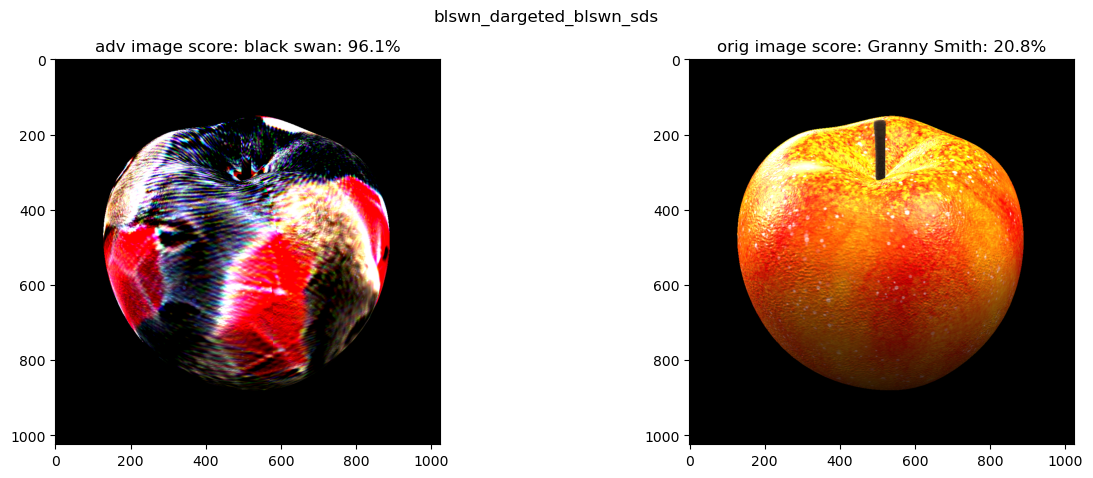

In [58]:
save_plots(plots,t='blswn_dargeted_blswn_sds',name='blswn_dargeted_blswn_sds.gif')

In [ ]:
import objaverse

uids = ['387d4d1a566b41ffac23d666f4dbddbd']

objaverse.load_objects(
    uids,
    download_processes = 1
)
print(os.listdir(f'{os.path.expanduser("~")}/.objaverse/hf-objaverse-v1/glbs/'))

# orig_mesh = kal.io.obj.import_mesh('/home/dcor/niskhizov/sheet-001.obj')
orig_mesh = kal.io.gltf.import_mesh('/home/dcor/niskhizov/ImageToStl.com_a4-sheet-003.glb')
orig_mesh.vertices = kal.ops.pointcloud.center_points(orig_mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)

['000-027', '000-046']


In [ ]:
# mesh = kal.io.obj.import_mesh("/home/dcor/niskhizov/sheet-001.obj")



# mesh.face_normals  # Causes face_normals and any attributes required to compute it to be auto-computed

# mesh.to_batched()  # Apply fixed topology batching, unsqueezing most attributes

# mesh = mesh.cuda(attributes=["vertices"])  # Moves just vertices to GPU

# print(mesh)


SurfaceMesh object with batching strategy Batching.FIXED
            vertices: [1, 482, 3] (torch.float32)[cuda:0]  
               faces: [480, 4] (torch.int64)[cpu]  
       face_vertices: if possible, computed on access from: (faces, vertices)
        face_normals: if possible, computed on access from: (normals, face_normals_idx) or (vertex_normals, faces) or (vertices, faces)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_features: if possible, computed on access from: (faces, face_features)
       face_tangents: if possible, computed on access from: (faces, vertex_tangents)
         face_colors: if possible, computed on access from: (faces, vertex_colors)
       face_fe

In [ ]:
(camera, _), (r, phi, theta) = random_camera_and_light(r_range = [1.5, 4])#,phi_range=[ 0.2,0.2] ,theta_range=[math.pi / 2 - theta_eps, math.pi / 2 - theta_eps])
lighting, (strength,light_directions) = random_light(strength_range=[20,30])#kal.render.easy_render.default_lighting().cuda()
print(strength,light_directions)
# lighting.amplitude = torch.ones(1,3).cuda() * 8

print(r)


# mesh.materials[0].diffuse_texture = mesh.materials[0].diffuse_texture

img = render(camera, mesh.cuda(), lighting.cuda())

26.21578860930059 tensor([[ 0.8053,  0.3377,  0.4874],
        [ 0.1307,  0.0764, -0.9885],
        [-0.5759,  0.7660, -0.2857],
        [-0.1302,  0.8883, -0.4404]], device='cuda:0', dtype=torch.float64)
3.243554199763369


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
!wget https://downloadscdn8.freepik.com/53A180JC-sheet-001/sheet-001-obj.zip?token=exp=1733567183~hmac=26f352ecc801af6794fb9c62fd54b271

--2024-12-07 12:25:27--  https://downloadscdn8.freepik.com/53A180JC-sheet-001/sheet-001-obj.zip
Resolving downloadscdn8.freepik.com (downloadscdn8.freepik.com)... 128.139.199.9, 128.139.199.6, 2001:bf8:900:3::808b:c706, ...
Connecting to downloadscdn8.freepik.com (downloadscdn8.freepik.com)|128.139.199.9|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-12-07 12:25:27 ERROR 403: Forbidden.



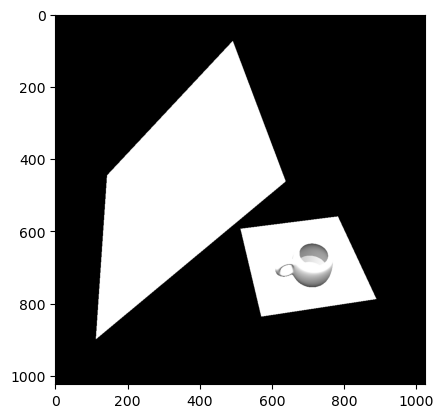

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img.detach().cpu())